# Constructing brain-specific interaction networks

The integrated network is consisted of information derived from multiple tissues under various biological conditions. Various studies have stressed the importance of applying tissue-specific interaction networks for data analysis. In previous examples, we employed the complete network for data analysis. Here, we show the flexibility of ReNet to construct brain-specific interaction networks for data analysis. 

We used the gene expression data from [Bgee](https://bgee.org/). Bgee contains expression data derived from multiple data types (RNA-Seq, Affymetrix, *in situ* hybridization, and EST data) for multiple organisms. Here, we used the calls of baseline presence/absense of gene expressed in human.

## Download and process Bgee data

In [1]:
import os
import urllib.request
import requests

project_directory = '/projects/ooihs/ReNet/'
data_directory = os.path.join(project_directory, 'data')

def retrieve_file(url, output):
    """save the url to a output. The output can be a directory or
    file. If the output is a directory, then save the filename pointed
    by the url into the directory.
    
    Return the local file with complete path.
    """
    try:
        localfile = output
        if os.path.isdir(output):
            localfile = os.path.join(output, url.split('/')[-1])
            
        download_file, headers = urllib.request.urlretrieve(url, localfile)
        return download_file
    except:
        return None

# download the calls in simple format, which shows only combined
# evidence from multiple data types
url = 'ftp://ftp.bgee.org/current/download/calls/expr_calls/Homo_sapiens_expr_simple_development.tsv.zip'

bgee_directory = os.path.join(data_directory, 'bgee')

if not os.path.isdir(bgee_directory):
    os.makedirs(bgee_directory)

filename = retrieve_file(url, bgee_directory)
if filename:
    print('Downloaded', filename)
else:
    print('Failed', url)

Downloaded /projects/ooihs/ReNet/data/bgee/Homo_sapiens_expr_simple_development.tsv.zip


In [2]:
!unzip -o {filename} -d {bgee_directory}

Archive:  /projects/ooihs/ReNet/data/bgee/Homo_sapiens_expr_simple_development.tsv.zip
  inflating: /projects/ooihs/ReNet/data/bgee/Homo_sapiens_expr_simple_development.tsv  


The uncompressed file is a tab-separated file, where we are interested in columns such as 'Anatomical entity ID', 'Expression', and 'Call quality'.

In [3]:
!head -n 2 {filename[:-4]}

Gene ID	"Gene name"	Anatomical entity ID	"Anatomical entity name"	Developmental stage ID	"Developmental stage name"	Expression	Call quality	Expression rank
ENSG00000000003	"TSPAN6"	CL:0000015	"male germ cell"	HsapDv:0000092	"human middle aged stage (human)"	present	silver quality	9.77e3


Next, we convert the expression data into profiles and standardize the genes into uniprot entries.

In [4]:
from src import bgee, uniprot

sprot_db = os.path.join(project_directory, 'results/sprot')
map_directory = os.path.join(project_directory, 'results/map/')
final_directory = os.path.join(project_directory, 'results/final/')

bgee.process(filename[:-4], # process the call file in simple format
             map_directory, # to map_directory
             '9606',        # human expression data
             ['gold quality'] # used only gold quality
            )

print()

uniprot.convert_participant(map_directory, 'tissue', 'bgee', sprot_db) 
print()

uniprot.convert_profile(map_directory, 'tissue', 'bgee') 

Processing Bgee Collection
Total number of records processed: 33172849
Total number of unique tissues: 152
Total number of unique molecules: 55192

Converting participants to uniprot accessions
Total interactors: 55192
Total interactors with valid conversion: 19449
Conversion rate: 35.24%

Converting profiles to uniprot accession
Total profiles: 152
Profiles with valid uniprot accession: 152
Conversion rate: 100.00%


## Select brain-related profiles

The downloaded expression data contains various tissue types. For example, a simple search through the tissues showed that there exists at least three brain-related tissues. Therefore, we need a way to select the brain-related profiles. Luckily, Bgee uses Uberon ontology to reresent the anatomical entities. 

In [5]:
!grep brain {map_directory}tissue.bgee.uniprot | cut -f1,2

UBERON:0000955	brain
UBERON:0001890	forebrain
UBERON:0001891	midbrain


We first download ontology from the [Uberon website](http://uberon.github.io/). The recommended version (Extended version) will be used.

In [6]:
url = 'http://purl.obolibrary.org/obo/uberon/ext.obo'
uberon_directory = os.path.join(data_directory, 'uberon')

if not os.path.isdir(uberon_directory):
    os.makedirs(uberon_directory)

uberon_file = retrieve_file(url, uberon_directory)
if uberon_file:
    print('Downloaded', uberon_file)
else:
    print('Failed', url)

Downloaded /projects/ooihs/ReNet/data/uberon/ext.obo


Similarly, we can load the Uberon ontology using the `obo` module.

In [7]:
from src import obo
uberon_file = '/projects/ooihs/ReNet/data/uberon/ext.obo'
# by default
# load the ontology, and build a directed-graph with is_a relationship.
uberon = obo.OBO(uberon_file)

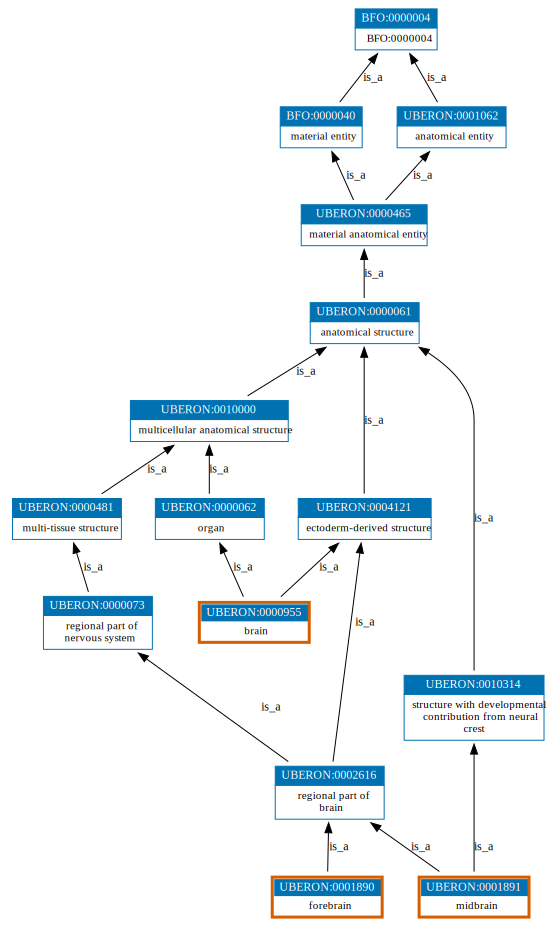

In [8]:
uberon.draw_terms(['UBERON:0000955', 'UBERON:0001890', 'UBERON:0001891'])

The above figure shows only the children with `is_a` relationships. However, `midbrain` and `forebrain` are different parts of brain. Therefore, we should use `part_of` relationship as well.

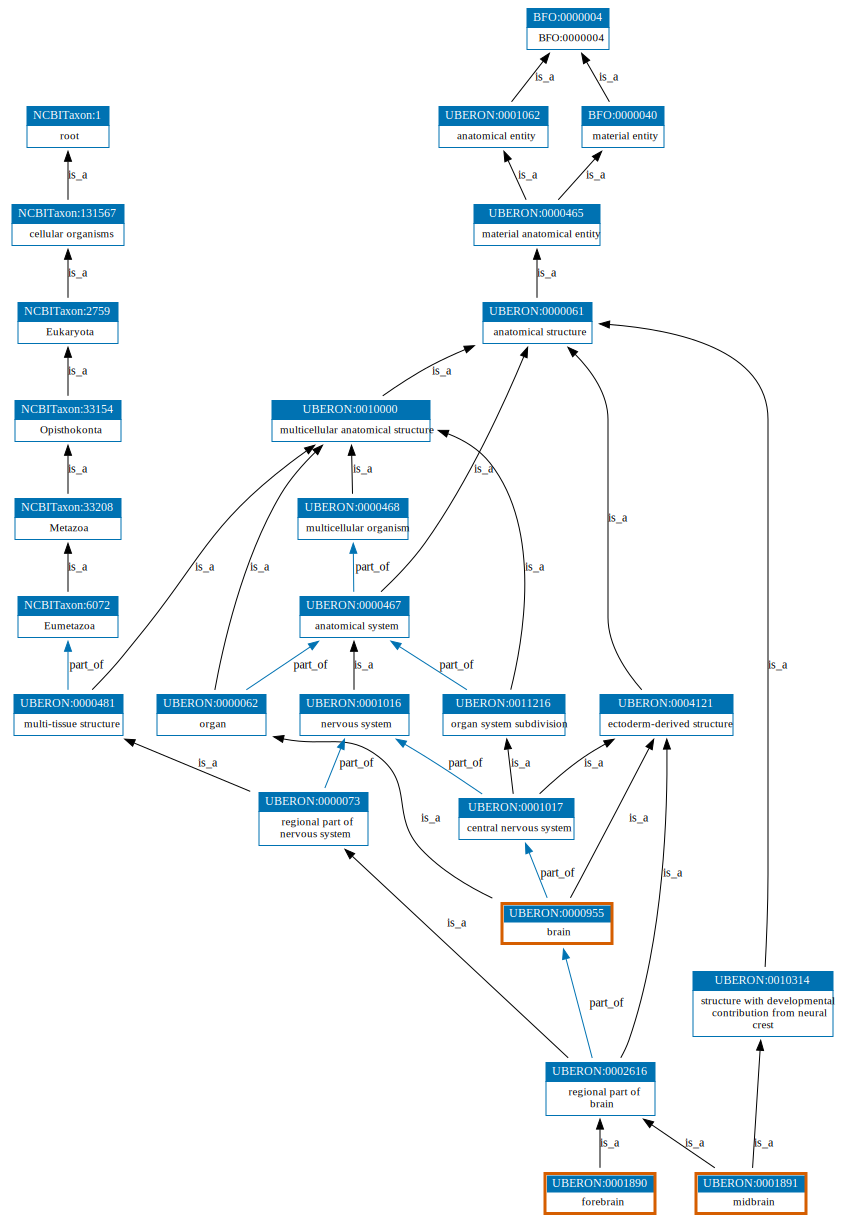

In [9]:
# rebuild the graph with part_of relationship
uberon.build_dag(relationships=['part_of'])
uberon.draw_terms(['UBERON:0000955', 'UBERON:0001890', 'UBERON:0001891'])

Now, the graph shows that both `forebrain` and `midbrain` are `regional part of brain`, which is `part_of` brain. Now, we can select all the decendants of `brain` and use them to select brain-related profiles.

In [10]:
import os
from src import geneset
import pandas as pd


project_directory = '/projects/ooihs/ReNet/'
data_directory = os.path.join(project_directory, 'data')
map_directory = os.path.join(project_directory, 'results/map/')
final_directory = os.path.join(project_directory, 'results/final/')

uberon_brain = 'UBERON:0000955'
brain_proteins = set()
brain_terms = set(uberon.descendants(uberon_brain))
brain_terms.add(uberon_brain)
print('Number of brain-related terms:', len(brain_terms))

bgee_file = os.path.join(map_directory, 'tissue.bgee.uniprot')
bgee = geneset.load(bgee_file)

brain_profiles = []
data = []
for profile in bgee:
    if profile in brain_terms:
        data.append([profile, uberon.get_term(profile)['name'], len(bgee[profile])])
        # aggregrate all genes expressed in brain
        brain_proteins.update(bgee[profile])
        brain_profiles.append(profile)
        
print('Number of brain-related profiles found:', len(brain_profiles))
print('Number of proteins expressed in brain-related profiles:', len(brain_proteins))
print('Is accumulated brain-related genes same as UBERON:000955?', brain_proteins == set(bgee[uberon_brain]))

brain_profiles_table = pd.DataFrame(data=data, columns=['ID', 'Name', 'Count'])
brain_profiles_table.sort_values('Count', ascending=False)

Number of brain-related terms: 1921
Number of brain-related profiles found: 33
Number of proteins expressed in brain-related profiles: 17641
Is accumulated brain-related genes same as UBERON:000955? True


,ID,Name,Count
2,UBERON:0000955,brain,17641
4,UBERON:0001870,frontal cortex,16450
3,UBERON:0000956,cerebral cortex,15210
1,UBERON:0000451,prefrontal cortex,15147
16,UBERON:0002037,cerebellum,14671
15,UBERON:0001954,Ammon's horn,13779
0,UBERON:0000007,pituitary gland,12689
25,UBERON:0009834,dorsolateral prefrontal cortex,12358
5,UBERON:0001873,caudate nucleus,12254
17,UBERON:0002038,substantia nigra,12122


Here, the number of genes that expressed in brain-related tissues are large. Generally, the brain is a large organ consisted of multiple tissue types. Futhermore, Bgee propagates calls of expression to paraent anatomical entities. For example, genes expressed in midbrain are also considered to be expressed in brain. From above table, the number of genes in brain is 17641, which is the same as when we aggregated all genes expressed in brain-related tissues.

Here, we compared the gene expressed in different part of brains. First, we show the different regions of a brain.

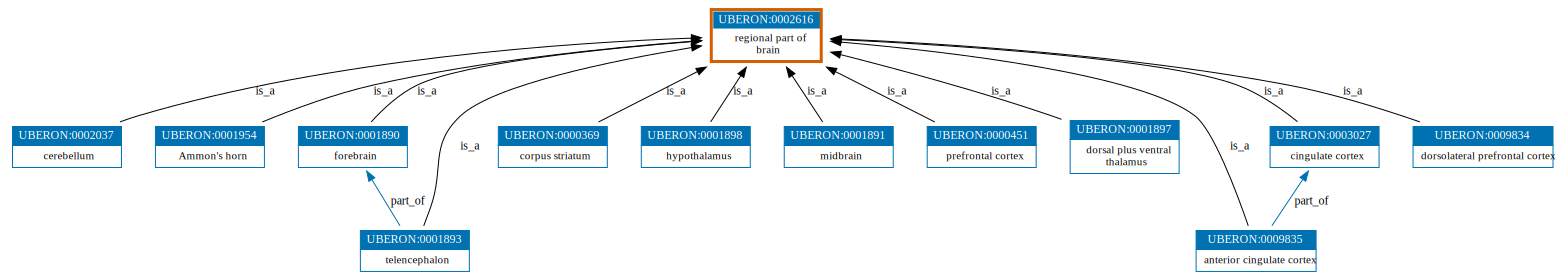

In [11]:
nodes = set()
nodes.add('UBERON:0002616') # regional part of brain
# add parts of brain in our collection
tissues = [item for item in uberon.children('UBERON:0002616') if item in brain_profiles]
nodes.update(tissues)
uberon.draw_graph(nodes, ['UBERON:0002616'])

Given that telencephalon and anterior cingulate cortex are also part of forebrain and cingulate cortex respectively, we will exclude thm in the comparison. Furthermore, corpus striatum is excluded as well, as there is only 3 annotated genes.

In [12]:
from IPython.display import display

removed_entries = ['UBERON:0001893', 'UBERON:0009835', 'UBERON:0000369']
for item in removed_entries:
    if item in tissues:
        tissues.remove(item)

comparative_result = pd.DataFrame(0, index=tissues, columns=tissues)

unique = {}
# find all overlap between profiles
for i, item in enumerate(tissues):
    item_set = set(bgee[item])    
    for nitem in tissues[i:]:            
        # overlap between two profiles
        nitem_set = set(bgee[nitem])
        comparative_result.loc[item, nitem] = len(item_set & nitem_set) 
        if item != nitem:
            # differences between two profiles
            comparative_result.loc[nitem, item] = '({},{})'.format(len(item_set - nitem_set), len(nitem_set -item_set))

    # find unqiue items
    other_set = set()
    for nitem in tissues:
        if item != nitem:
            other_set.update(bgee[nitem])
    unique[item] = len(item_set - other_set)
            
# rename the table
tissue_name = {item: uberon.get_term(item).get('name', item) for item in tissues}
print('Genes expressed in selected tissues:')
comparative_result = comparative_result.rename(index=tissue_name, columns=tissue_name)
display(comparative_result)

print()
print('Genes uniquely expressed in selected tissues:')
unique_result = pd.DataFrame(data=list(unique.values()), index=unique.keys(), columns=['Count'])
unique_result = unique_result.rename(index=tissue_name)
display(unique_result)

Genes expressed in selected tissues:


,prefrontal cortex,forebrain,midbrain,dorsal plus ventral thalamus,hypothalamus,Ammon's horn,cerebellum,cingulate cortex,dorsolateral prefrontal cortex
prefrontal cortex,15147,10909,11370,4228,11413,13209,14155,6501,12187
forebrain,"(4238,153)",11062,10117,4079,10169,10974,10778,6085,10648
midbrain,"(3777,174)","(945,1427)",11544,4228,11052,11489,11248,6318,11113
dorsal plus ventral thalamus,"(10919,8)","(6983,157)","(7316,8)",4236,4230,4235,4228,3958,4229
hypothalamus,"(3734,195)","(893,1439)","(492,556)","(6,7378)",11608,11529,11309,6335,11167
Ammon's horn,"(1938,570)","(88,2805)","(55,2290)","(1,9544)","(79,2250)",13779,12890,6495,12241
cerebellum,"(992,516)","(284,3893)","(296,3423)","(8,10443)","(299,3362)","(889,1781)",14671,6479,11979
cingulate cortex,"(8646,28)","(4977,444)","(5226,211)","(278,2571)","(5273,194)","(7284,34)","(8192,50)",6529,6478
dorsolateral prefrontal cortex,"(2960,171)","(414,1710)","(431,1245)","(7,8129)","(441,1191)","(1538,117)","(2692,379)","(51,5880)",12358



Genes uniquely expressed in selected tissues:


,Count
prefrontal cortex,438
forebrain,35
midbrain,14
dorsal plus ventral thalamus,1
hypothalamus,25
Ammon's horn,211
cerebellum,272
cingulate cortex,6
dorsolateral prefrontal cortex,24


The top part of the `comparative_results` table shows the genes expressed in both profiles, while the bottom part shows the differences between two profiles. For example, the number of genes expressed in `prefrontal cortex` and `forbrain` is 15147 and 11062 respectively. The number of genes expressed in both profiles is 10909. This means that there are 4238 genes expressed in `prefrontal cortex` but not `forebrain`. Similarly, there are 153 genes expressed in `forbrain` but not `prefrontal cortex`. Furthermore, the are genes uniquely expressed in each brain tissue. Therefore, there is a need the ability to construct a tissue-specific network for functional study.

## Building brain-specific interaction networks

Generally, the human body is consisted of many organs or tissues. Recent studies have shown that each of these tissues contains a distinct set of expressed genes. As a consequent, the protein interactome will change across tissues. Therefere, we need an effective way to derive context-specific networks for different studies. This tissue-specific view of protein-protein interaction network could be used for assessing the functional roles of human proteins in a specific tissue. We used the combination of UBERON ontology and Bgee expression calls data to provide users with an effective means to derive a tissue-specific network.

The advancement of recent technology has generated a large amount of genes associated with schizophrenia. Given that a brain is a large organ consisted of multiple parts, we are interested in finding the functional roles of these genes across different brain parts. 

### Loading the global network

In [13]:
from networkx import nx

project_directory = '/projects/ooihs/ReNet'
final_directory = os.path.join(project_directory, 'results/final')
network_file = os.path.join(final_directory, 'integrated.network.uniprot')

def load_network(network_file, lr_cutoff=0):
    """Load the integrated network, with likelihood ratio"""
    graph = nx.Graph()
    with open(network_file) as ifh:
        for line in ifh:
            col = line.strip().split('\t')
            info = json.loads(col[2])
            if info['lr'] >= lr_cutoff:
                graph.add_edge(col[0], col[1], lr=info['lr'])

    return graph
            
network = load_network(network_file)
print('Network loaded:')
print('Proteins:', network.number_of_nodes())
print('Interactions:', network.number_of_edges())

Network loaded:
Proteins: 19185
Interactions: 1231170


### Extract schizophrenia-associated genes from GWAS Catalog

In [14]:
from src import misc

gwas_directory = os.path.join(data_directory, 'gwas')
gwas_file = os.path.join(gwas_directory, 'gwas_catalog_v1.0-associations_e90_r2017-11-20.tsv')

# only genes from REPORTED GENE(S) (14-th column) will be used.
szgenes = set()
with open(gwas_file) as ifh:
    for line in ifh:
        col = line.strip().split('\t')
        
        # we collect genes from all studies with 'schizophrenia' appear
        # in DISEASE/TRAIT column
        if 'schizophrenia' in col[7].lower():
            # REPORTED GENE(S) are splitted by ,
            szgenes.update([g.strip() for g in col[13].split(',')])
            
print('Total number of items loaded:', len(szgenes))

hgnc_file = os.path.join(data_directory, 'hgnc/hgnc_complete_set.json')
hgnc = misc.load_hgnc_json(hgnc_file)

# build a gene symbol to uniprot mapping
gene2uniprot = {}
for item in hgnc['uniprot']:
    gene2uniprot[hgnc['uniprot'][item]] = item
    
# convert the szgenes to szproteins
szproteins = set([gene2uniprot[gene] for gene in szgenes if gene in gene2uniprot])

background_proteins = list(hgnc['uniprot'].keys())

print('Total number of proteins obtained:', len(szproteins))

Total number of items loaded: 1270
Total number of proteins obtained: 949


### Check the expressed patterns of the schizophrenia-associated genes across different brain parts

In [15]:
szprotein_calls = {}
for i, item in enumerate(tissues):
    szprotein_calls[item] = szproteins & set(bgee[item])
            
print('Schizophrenia-associated proteins found in selected tissues:')
data = [len(szprotein_calls[tissue]) for tissue in szprotein_calls.keys()]
szprotein_call_result = pd.DataFrame(data=data, 
                                     index=szprotein_calls.keys(), 
                                     columns=['Count'])
szprotein_call_result = szprotein_call_result.rename(index=tissue_name)
display(szprotein_call_result)

szprotein_comparative_result = pd.DataFrame(0, index=tissues, columns=tissues)

szprotein_unique = {}
# find all overlap between profiles
for i, item in enumerate(tissues):
    item_set = szprotein_calls[item]
    
    for nitem in tissues[i:]:            
        # overlap between two profiles
        nitem_set = szprotein_calls[nitem]
        szprotein_comparative_result.loc[item, nitem] = len(item_set & nitem_set) 
        if item != nitem:
            # differences between two profiles
            szprotein_comparative_result.loc[nitem, item] = '({},{})'.format(
                len(item_set - nitem_set), len(nitem_set -item_set))

    # find unqiue items
    other_set = set()
    for nitem in tissues:
        if item != nitem:
            other_set.update(szprotein_calls[nitem])
    szprotein_unique[item] = len(item_set - other_set)

print()
print('Comparison of schizophrenia-associated proteins in selected tissues:')
szprotein_comparative_result = szprotein_comparative_result.rename(index=tissue_name, columns=tissue_name)
display(szprotein_comparative_result)

print()
print('Schizophrenia-associated proteins uniquely expressed in selected tissues:')
szprotein_unique_result = pd.DataFrame(data=list(szprotein_unique.values()), index=szprotein_unique.keys(), columns=['Count'])
szprotein_unique_result = szprotein_unique_result.rename(index=tissue_name)
display(szprotein_unique_result)

Schizophrenia-associated proteins found in selected tissues:


,Count
prefrontal cortex,812
forebrain,594
midbrain,592
dorsal plus ventral thalamus,249
hypothalamus,602
Ammon's horn,722
cerebellum,779
cingulate cortex,380
dorsolateral prefrontal cortex,657



Comparison of schizophrenia-associated proteins in selected tissues:


,prefrontal cortex,forebrain,midbrain,dorsal plus ventral thalamus,hypothalamus,Ammon's horn,cerebellum,cingulate cortex,dorsolateral prefrontal cortex
prefrontal cortex,812,591,587,248,595,699,762,380,651
forebrain,"(221,3)",594,532,239,538,591,578,357,575
midbrain,"(225,5)","(62,60)",592,247,570,591,584,368,581
dorsal plus ventral thalamus,"(564,1)","(355,10)","(345,2)",249,248,249,248,233,248
hypothalamus,"(217,7)","(56,64)","(22,32)","(1,354)",602,602,593,369,588
Ammon's horn,"(113,23)","(3,131)","(1,131)","(0,473)","(0,120)",722,683,380,653
cerebellum,"(50,17)","(16,201)","(8,195)","(1,531)","(9,186)","(39,96)",779,374,638
cingulate cortex,"(432,0)","(237,23)","(224,12)","(16,147)","(233,11)","(342,0)","(405,6)",380,377
dorsolateral prefrontal cortex,"(161,6)","(19,82)","(11,76)","(1,409)","(14,69)","(69,4)","(141,19)","(3,280)",657



Schizophrenia-associated proteins uniquely expressed in selected tissues:


,Count
prefrontal cortex,26
forebrain,1
midbrain,0
dorsal plus ventral thalamus,0
hypothalamus,0
Ammon's horn,10
cerebellum,10
cingulate cortex,0
dorsolateral prefrontal cortex,0


### Analyzinsg the brain-specific interaction networks

In [16]:
node_count = []
edge_count = []
connected_component_count = []
largest_subgraph_count = []
percentage_subgraph_count = []

for item in tissues:
    # obtain a subgraph from the global interaction network
    subnet = network.subgraph(szprotein_calls[item])
    node_count.append(subnet.number_of_nodes())
    edge_count.append(subnet.number_of_edges())
    connected_component_count.append(nx.number_connected_components(subnet))
    largest_subgraph = max(nx.connected_component_subgraphs(subnet), key=len)
    largest_subgraph_count.append((largest_subgraph.number_of_nodes(), 
                                 largest_subgraph.number_of_edges()))
    percentage_subgraph_count.append('({:.2%}, {:.2%})'.format(
        (largest_subgraph.number_of_nodes() / subnet.number_of_nodes()),
        (largest_subgraph.number_of_edges() / subnet.number_of_edges())
    ))
    
    
data = list(zip(node_count, 
                edge_count, 
                connected_component_count, 
                largest_subgraph_count, 
                percentage_subgraph_count))
columns = ['Node', 
           'Interaction', 
           'Connected Component', 
           'Largest Subgraph (node, interaction)', 
           'Largest Subgraph (percentages)']
sznetwork_result = pd.DataFrame(data=data,
                               index=tissues,
                               columns=columns)
sznetwork_result = sznetwork_result.rename(index=tissue_name)
sznetwork_result

,Node,Interaction,Connected Component,"Largest Subgraph (node, interaction)",Largest Subgraph (percentages)
prefrontal cortex,804,3560,173,"(626, 3551)","(77.86%, 99.75%)"
forebrain,591,2220,122,"(469, 2219)","(79.36%, 99.95%)"
midbrain,590,2275,108,"(479, 2271)","(81.19%, 99.82%)"
dorsal plus ventral thalamus,248,703,47,"(197, 698)","(79.44%, 99.29%)"
hypothalamus,600,2159,111,"(487, 2156)","(81.17%, 99.86%)"
Ammon's horn,718,2901,143,"(572, 2896)","(79.67%, 99.83%)"
cerebellum,775,3510,154,"(613, 3498)","(79.10%, 99.66%)"
cingulate cortex,379,1356,60,"(317, 1353)","(83.64%, 99.78%)"
dorsolateral prefrontal cortex,654,2601,124,"(529, 2599)","(80.89%, 99.92%)"


## KEGG pathway enrichment analysis

The above table shows that the largest subgraph of each brain-specific tissue covers more than 99% of interaction in each corresponding network. Therefore, we apply the over-represetation test on the largest subgraph. The above analysis also shows that the schizophrenia associated proteins are highly connected.

In [17]:
from src import ora

kegg_file = os.path.join(map_directory, 'pathway.kegg.uniprot')
kegg_enrichments = {}

for item in tissues:
    # obtain a subgraph from the global interaction network
    subnet = network.subgraph(szprotein_calls[item])
    largest_subgraph = max(nx.connected_component_subgraphs(subnet), key=len)
    kegg_enrichments[item] = ora.network_test(largest_subgraph, 
                                              kegg_file, 
                                              len(background_proteins))
    print(tissue_name[item])
    display(kegg_enrichments[item])
    print()

prefrontal cortex


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome
0,hsa04940,Type I diabetes mellitus,6.542851e-15,1.472951e-12,17/626,44/20030
1,hsa05322,Systemic lupus erythematosus,1.640463e-14,1.472951e-12,23/626,96/20030
2,hsa04612,Antigen processing and presentation,1.833549e-14,1.472951e-12,21/626,78/20030
3,hsa05330,Allograft rejection,3.554953e-12,2.141859e-10,14/626,38/20030
4,hsa05150,Staphylococcus aureus infection,6.576903e-12,3.170067e-10,16/626,55/20030
5,hsa05332,Graft-versus-host disease,1.731325e-11,6.954154e-10,14/626,42/20030
6,hsa05168,Herpes simplex infection,1.284299e-10,4.421659e-09,26/626,184/20030
7,hsa05416,Viral myocarditis,2.507411e-10,7.553576e-09,15/626,59/20030
8,hsa05320,Autoimmune thyroid disease,4.341221e-10,1.162483e-08,14/626,52/20030
9,hsa04145,Phagosome,1.900932e-09,4.581247e-08,22/626,151/20030



forebrain


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome
0,hsa04360,Axon guidance,0.000015,0.003493,15/469,174/20030
1,hsa05203,Viral carcinogenesis,0.000030,0.003493,15/469,184/20030
2,hsa05169,Epstein-Barr virus infection,0.000074,0.003979,15/469,199/20030
3,hsa03018,RNA degradation,0.000085,0.003979,9/469,78/20030
4,hsa04612,Antigen processing and presentation,0.000085,0.003979,9/469,78/20030
5,hsa04520,Adherens junction,0.000274,0.010649,8/469,72/20030
6,hsa05168,Herpes simplex infection,0.000413,0.013742,13/469,184/20030
7,hsa04940,Type I diabetes mellitus,0.000530,0.015433,6/469,44/20030
8,hsa04728,Dopaminergic synapse,0.000982,0.025422,10/469,130/20030
9,hsa03015,mRNA surveillance pathway,0.001146,0.026699,8/469,89/20030



midbrain


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome
0,hsa04612,Antigen processing and presentation,3.382433e-12,8.016367e-10,17/479,78/20030
1,hsa04940,Type I diabetes mellitus,3.213135e-10,3.807565e-08,12/479,44/20030
2,hsa05330,Allograft rejection,8.767912e-10,6.926650e-08,11/479,38/20030
3,hsa05332,Graft-versus-host disease,2.860925e-09,1.633838e-07,11/479,42/20030
4,hsa05168,Herpes simplex infection,3.446915e-09,1.633838e-07,21/479,184/20030
5,hsa05416,Viral myocarditis,1.231848e-08,4.865798e-07,12/479,59/20030
6,hsa05320,Autoimmune thyroid disease,3.253723e-08,1.101618e-06,11/479,52/20030
7,hsa04145,Phagosome,1.319280e-07,3.908368e-06,17/479,151/20030
8,hsa05169,Epstein-Barr virus infection,3.352528e-07,8.828324e-06,19/479,199/20030
9,hsa04672,Intestinal immune network for IgA production,1.442141e-06,3.417873e-05,9/479,47/20030



dorsal plus ventral thalamus


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome
0,hsa04612,Antigen processing and presentation,4.744316e-09,8.634654e-07,10/197,78/20030
1,hsa04940,Type I diabetes mellitus,9.938318e-09,9.043869e-07,8/197,44/20030
2,hsa05330,Allograft rejection,7.800284e-08,4.732172e-06,7/197,38/20030
3,hsa05416,Viral myocarditis,1.096196e-07,4.987693e-06,8/197,59/20030
4,hsa05332,Graft-versus-host disease,1.612935e-07,5.871084e-06,7/197,42/20030
5,hsa05169,Epstein-Barr virus infection,6.764685e-07,1.913836e-05,12/197,199/20030
6,hsa05320,Autoimmune thyroid disease,7.360909e-07,1.913836e-05,7/197,52/20030
7,hsa04514,Cell adhesion molecules (CAMs),1.651094e-06,3.756240e-05,10/197,144/20030
8,hsa05168,Herpes simplex infection,2.168957e-06,4.386112e-05,11/197,184/20030
9,hsa04145,Phagosome,2.539126e-06,4.621209e-05,10/197,151/20030



hypothalamus


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome
0,hsa04612,Antigen processing and presentation,4.399429e-12,1.016268e-09,17/487,78/20030
1,hsa04940,Type I diabetes mellitus,3.881752e-10,4.483424e-08,12/487,44/20030
2,hsa05330,Allograft rejection,1.043473e-09,8.034739e-08,11/487,38/20030
3,hsa05332,Graft-versus-host disease,3.399745e-09,1.963353e-07,11/487,42/20030
4,hsa05416,Viral myocarditis,1.479868e-08,6.836989e-07,12/487,59/20030
5,hsa05168,Herpes simplex infection,2.481984e-08,9.555638e-07,20/487,184/20030
6,hsa05320,Autoimmune thyroid disease,3.852222e-08,1.271233e-06,11/487,52/20030
7,hsa04145,Phagosome,1.668826e-07,4.818735e-06,17/487,151/20030
8,hsa04672,Intestinal immune network for IgA production,1.653010e-06,4.242726e-05,9/487,47/20030
9,hsa05169,Epstein-Barr virus infection,1.898793e-06,4.386212e-05,18/487,199/20030



Ammon's horn


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome
0,hsa04940,Type I diabetes mellitus,1.483651e-15,3.634945e-13,17/572,44/20030
1,hsa04612,Antigen processing and presentation,4.750312e-13,5.819133e-11,19/572,78/20030
2,hsa05332,Graft-versus-host disease,5.190572e-12,4.238967e-10,14/572,42/20030
3,hsa05330,Allograft rejection,2.065311e-11,1.265003e-09,13/572,38/20030
4,hsa05168,Herpes simplex infection,5.766253e-10,2.825464e-08,24/572,184/20030
5,hsa05322,Systemic lupus erythematosus,1.699982e-09,6.941595e-08,17/572,96/20030
6,hsa05416,Viral myocarditis,8.907972e-09,3.117790e-07,13/572,59/20030
7,hsa05320,Autoimmune thyroid disease,1.909021e-08,5.846378e-07,12/572,52/20030
8,hsa05321,Inflammatory bowel disease (IBD),3.089477e-08,8.410242e-07,13/572,65/20030
9,hsa04145,Phagosome,6.471901e-08,1.585616e-06,19/572,151/20030



cerebellum


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome
0,hsa05322,Systemic lupus erythematosus,9.700823e-16,2.337898e-13,24/613,96/20030
1,hsa04940,Type I diabetes mellitus,9.186715e-14,1.106999e-11,16/613,44/20030
2,hsa04612,Antigen processing and presentation,1.605848e-12,1.290031e-10,19/613,78/20030
3,hsa05330,Allograft rejection,4.882983e-11,2.941997e-09,13/613,38/20030
4,hsa05150,Staphylococcus aureus infection,6.261552e-11,3.018068e-09,15/613,55/20030
5,hsa05168,Herpes simplex infection,8.143686e-11,3.271047e-09,26/613,184/20030
6,hsa05332,Graft-versus-host disease,2.056145e-10,7.079012e-09,13/613,42/20030
7,hsa05416,Viral myocarditis,2.037967e-09,6.139377e-08,14/613,59/20030
8,hsa05320,Autoimmune thyroid disease,3.862238e-09,1.034221e-07,13/613,52/20030
9,hsa04145,Phagosome,7.193424e-09,1.733615e-07,21/613,151/20030



cingulate cortex


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome
0,hsa04612,Antigen processing and presentation,3.426143e-09,7.400469e-07,12/317,78/20030
1,hsa04940,Type I diabetes mellitus,2.423591e-08,2.617478e-06,9/317,44/20030
2,hsa05330,Allograft rejection,1.165968e-07,8.394967e-06,8/317,38/20030
3,hsa05168,Herpes simplex infection,2.533390e-07,1.150617e-05,15/317,184/20030
4,hsa05332,Graft-versus-host disease,2.663465e-07,1.150617e-05,8/317,42/20030
5,hsa05416,Viral myocarditis,3.488298e-07,1.255787e-05,9/317,59/20030
6,hsa05169,Epstein-Barr virus infection,6.940851e-07,2.141748e-05,15/317,199/20030
7,hsa05320,Autoimmune thyroid disease,1.480170e-06,3.996458e-05,8/317,52/20030
8,hsa04145,Phagosome,5.281117e-06,1.267468e-04,12/317,151/20030
9,hsa04514,Cell adhesion molecules (CAMs),1.893595e-05,4.090165e-04,11/317,144/20030



dorsolateral prefrontal cortex


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome
0,hsa04612,Antigen processing and presentation,1.623389e-11,3.879900e-09,17/529,78/20030
1,hsa04940,Type I diabetes mellitus,6.452698e-11,7.710974e-09,13/529,44/20030
2,hsa05330,Allograft rejection,2.481061e-09,1.976578e-07,11/529,38/20030
3,hsa05168,Herpes simplex infection,3.746541e-09,2.238558e-07,22/529,184/20030
4,hsa05332,Graft-versus-host disease,8.020735e-09,3.833911e-07,11/529,42/20030
5,hsa05416,Viral myocarditis,3.680200e-08,1.465946e-06,12/529,59/20030
6,hsa05320,Autoimmune thyroid disease,8.913087e-08,3.043183e-06,11/529,52/20030
7,hsa04145,Phagosome,1.032099e-07,3.083395e-06,18/529,151/20030
8,hsa05322,Systemic lupus erythematosus,2.225038e-07,5.908713e-06,14/529,96/20030
9,hsa05169,Epstein-Barr virus infection,1.484081e-06,3.546953e-05,19/529,199/20030


### Distribution of enriched KEGG pathways across selected brain tissues

In [18]:
%matplotlib inline
from collections import Counter
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt

kegg_count = Counter()
for item in kegg_enrichments:
    kegg_count.update(kegg_enrichments[item]['Name'])
        
sorted_kegg = sorted(kegg_count.items(), key=itemgetter(1), reverse=True)
data = []
for item in sorted_kegg:
    name, count = item
    data.append((name, count))

kegg_result = pd.DataFrame(data, columns=['Pathway', 'Count'])

# associate the pathways with schizophrenia articles
article_file = os.path.join(final_directory, 'kegg_in_schizophrenia_articles.txt')
    
kegg_pubmed = {}
with open(article_file) as ifh:
    for line in ifh:
        col = line.strip().split('\t')
        kegg_pubmed[col[0]] = int(col[1])
        
kegg_result['Pubmed articles'] = [kegg_pubmed.get(pathway, 0) 
                                  for pathway in kegg_result['Pathway']]
display(kegg_result)

,Pathway,Count,Pubmed articles
0,Type I diabetes mellitus,9,0
1,Antigen processing and presentation,9,1
2,Allograft rejection,9,1
3,Graft-versus-host disease,9,1
4,Herpes simplex infection,9,1
5,Viral myocarditis,9,0
6,Epstein-Barr virus infection,9,3
7,Viral carcinogenesis,9,0
8,RNA degradation,9,5
9,Adherens junction,9,4


### Pathways common to all brain tissues

In [19]:
kegg_result[kegg_result['Count'] > 6]

,Pathway,Count,Pubmed articles
0,Type I diabetes mellitus,9,0
1,Antigen processing and presentation,9,1
2,Allograft rejection,9,1
3,Graft-versus-host disease,9,1
4,Herpes simplex infection,9,1
5,Viral myocarditis,9,0
6,Epstein-Barr virus infection,9,3
7,Viral carcinogenesis,9,0
8,RNA degradation,9,5
9,Adherens junction,9,4


A number of known schizophrenia-associated pathways such as `Axon guidance`, `Dopaminergic synapse`, and `Glutamatergic synapse` are available in 8 out of 9 brain tissues. While there are strong association between schizophrenia and `Type II diabetes mellitus` (T2DM), the association has not been well-established for `Type I diabetes mellitus` (T1DM). From `kegg_pubmed`, the number of associated articles for T2DM is 17, while is 0 for T1DM. However, we can see from the above that that T1DM pathway has been enriched across all brain tissues. Therefore, there is a need to study the schizophrenia-associated genes participated in this pathway for for analysis.

### Pathways uniquely presented in a specific brain tissue

In [20]:
kegg_result[kegg_result['Count'] < 3]

,Pathway,Count,Pubmed articles
56,Cholinergic synapse,2,5
57,Aldosterone synthesis and secretion,2,0
58,Kaposi's sarcoma-associated herpesvirus infection,2,0
59,Spliceosome,1,1
60,Central carbon metabolism in cancer,1,1
61,RNA transport,1,0
62,AGE-RAGE signaling pathway in diabetic complic...,1,0
63,Non-alcoholic fatty liver disease (NAFLD),1,4
64,Insulin resistance,1,268
65,Hepatitis C,1,49


Both `Insulin resistance` and `Circadian rhythm` have a high number of article support. Here, we search for the particular tissue with these pathways enriched.

In [21]:
pathways = ['Insulin resistance', 'Circadian rhythm']
for item in kegg_enrichments:
    result = kegg_enrichments[item]
    selected = result[result['Name'].isin(pathways)]
    if not selected.empty:
        print(tissue_name.get(item, item))
        display(selected)
        print()

Ammon's horn


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome
57,hsa04931,Insulin resistance,0.011628,0.048911,8/572,107/20030



cingulate cortex


,Pathway ID,Name,p-value,FDR,Count/Set,Count/Genome
53,hsa04710,Circadian rhythm,0.011623,0.045981,3/317,30/20030


## Conclusion

Here, we showed a simple workflow for performing tissue-specific data analysis using ReNet. We first used expression call data from Bgee to derive brain-specific interaction networks. The used of UBERON ontology allowed us to derive interaction networks for various brain tissues. Finally,  we applied the schizophrenia-associated genes obtained from GWAS Catalog to these networks to understand the pathways associated with different brain regions.